># Import Libraries

In [16]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import random

import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

># Data Loading

In [6]:
class config:
    IMG_WIDTH = 224
    IMG_HEIGHT = 224
    IMG_CHANNELS = 3
    BATCH_SIZE = 16
    EPOCHS = 30

In [7]:
image_path = 'phase_1_data/original'
all_files = os.listdir(image_path)
all_files.sort()

img_paths = [os.path.join(image_path, id_) for id_ in all_files]

X = []
for path in tqdm(img_paths):
    image = skimage.io.imread(path)[:,:,:3]
    image = skimage.transform.resize(image, output_shape=(config.IMG_HEIGHT,config.IMG_WIDTH), mode='constant', preserve_range=True)
    X.append(image)
X = np.array(X, dtype=np.uint8)

100%|██████████| 1428/1428 [00:53<00:00, 26.80it/s]


In [8]:
mask_path = 'phase_1_data/mask'
all_files = os.listdir(mask_path)
all_files.sort()

mask_paths = [os.path.join(mask_path, id_) for id_ in all_files]

y = []
for path_mask in tqdm(mask_paths):
    masks = skimage.io.imread_collection(path_mask).concatenate()
    mask = np.max(masks, axis=0)
    mask = skimage.transform.resize(mask, output_shape=(config.IMG_HEIGHT,config.IMG_WIDTH)+(1,), mode='constant', preserve_range=True)
    y.append(mask)
y = np.array(y, dtype=np.bool_)

100%|██████████| 1428/1428 [00:36<00:00, 39.44it/s] 


In [9]:
X.shape

(1428, 224, 224, 3)

In [10]:
y.shape

(1428, 224, 224, 1)

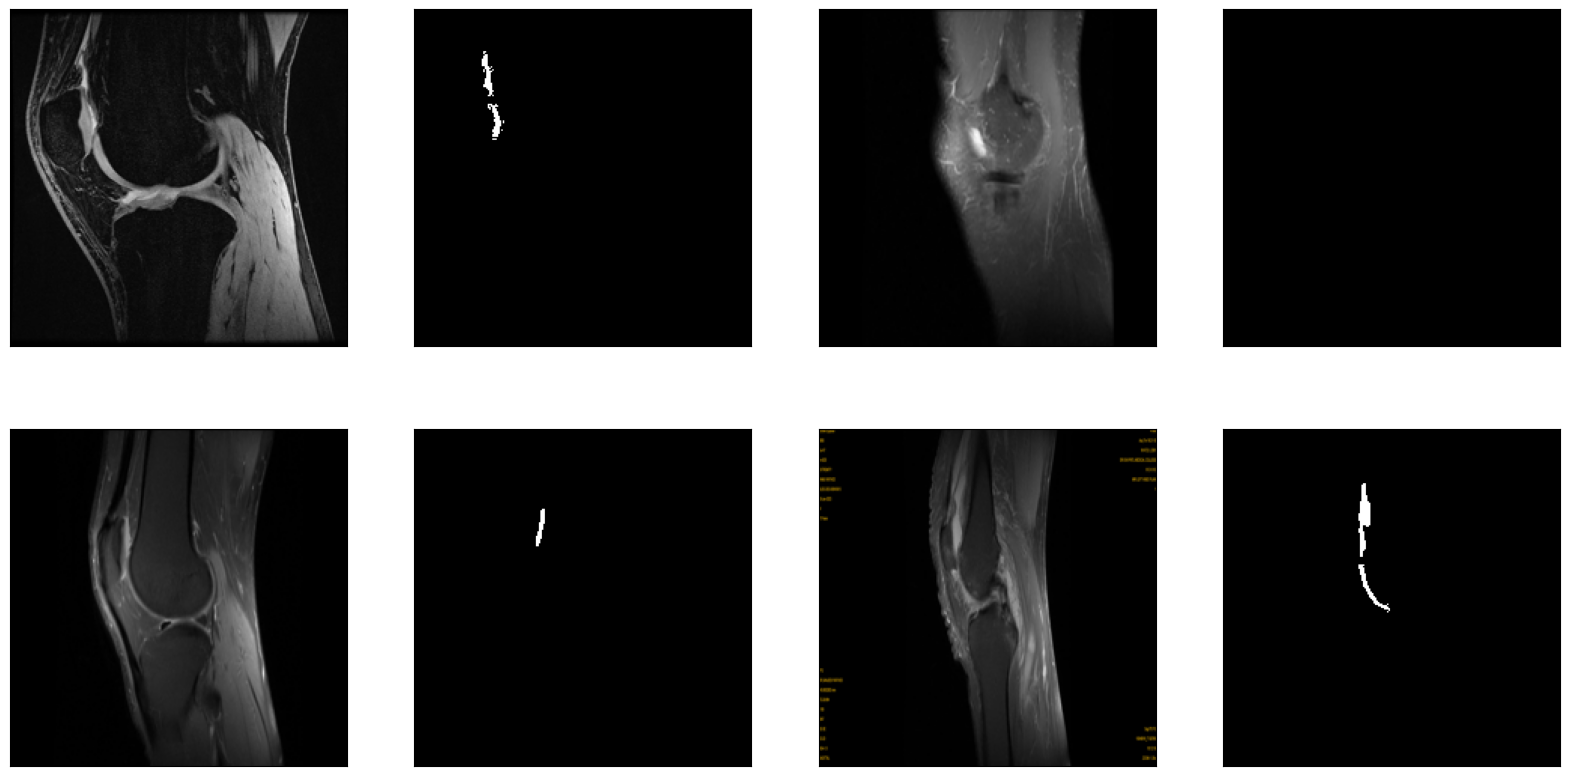

In [11]:
fig, axarr = plt.subplots(2, 4)
fig.set_size_inches(20, 10)

ix = random.randint(0, X.shape[0])
axarr[0, 0].imshow(X[ix])
axarr[0, 1].imshow(np.squeeze(y[ix]), cmap='gray')

ix = random.randint(0, X.shape[0])
axarr[0, 2].imshow(X[ix])
axarr[0, 3].imshow(np.squeeze(y[ix]), cmap='gray')

ix = random.randint(0, X.shape[0])
axarr[1, 0].imshow(X[ix])
axarr[1, 1].imshow(np.squeeze(y[ix]), cmap='gray')

ix = random.randint(0, X.shape[0])
axarr[1, 2].imshow(X[ix])
axarr[1, 3].imshow(np.squeeze(y[ix]), cmap='gray')

for row in axarr:
    for ax in row:
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

># Data Splitting

In [12]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=SEED)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1285, 224, 224, 3) (143, 224, 224, 3) (1285, 224, 224, 1) (143, 224, 224, 1)


># Custom Accuracy Functions

In [13]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def intersection_over_union(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

># Algorithm : UNET++

In [14]:
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]

inputs = Input((config.IMG_HEIGHT, config.IMG_WIDTH, config.IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([inputs], [nestnet_output_4])
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[dice_coefficient, intersection_over_union])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 224, 224, 32)         0         ['conv2d[0][0]']              
                                                                                              

In [17]:
checkpoint = ModelCheckpoint('model/UNET++_model.h5' ,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0)

callbacks_list = [checkpoint, reduce_lr]

># Model Training

history = model.fit(
    x=X,
    y=y,
    batch_size=config.BATCH_SIZE,
    callbacks=callbacks_list,
    epochs=config.EPOCHS,
    validation_data=(x_train, y_train),
)

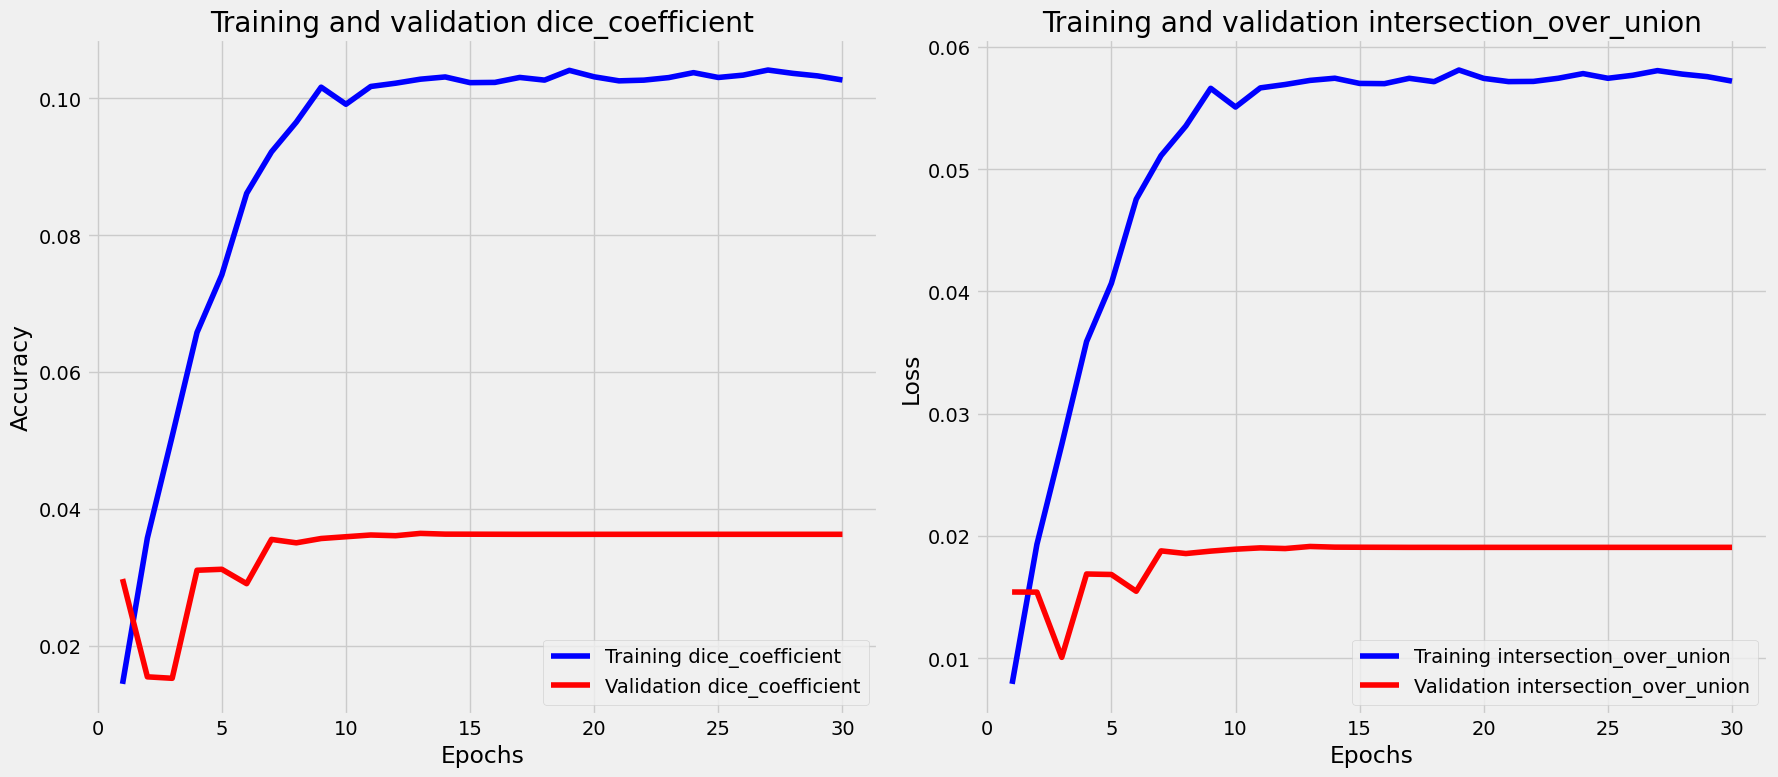

In [19]:
accuracy = history.history['dice_coefficient']
val_accuracy = history.history['val_dice_coefficient']
loss = history.history['intersection_over_union']
val_loss = history.history['val_intersection_over_union']
epochs = range(1, len(accuracy)+1)

with plt.style.context('fivethirtyeight'):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    axes[0].plot(epochs, accuracy, 'b', label='Training dice_coefficient')
    axes[0].plot(epochs, val_accuracy, 'r', label='Validation dice_coefficient')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title("Training and validation dice_coefficient")
    axes[0].legend()

    # Plot loss
    axes[1].plot(epochs, loss, 'b', label='Training intersection_over_union')
    axes[1].plot(epochs, val_loss, 'r', label='Validation intersection_over_union')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].set_title("Training and validation intersection_over_union")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

---

># Model Prediction

In [20]:
model_prediction = model.predict(x_test, batch_size=16, verbose=1)

9/9 [==============================] - 12s 1s/step


In [21]:
model_prediction.shape

(143, 224, 224, 1)

In [22]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (2. * intersection) / (union + 1e-7)

def intersection_over_union(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return intersection / (union + 1e-7)

dice = dice_coefficient(y_test, model_prediction)
iou = intersection_over_union(y_test, model_prediction)

print("Dice coefficient:", dice)
print("Intersection over Union:", iou)

># Displaying Generating Mask Randomly

In [ ]:
num_samples = 4
indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    original_image = x_test[idx]

    mask_image = model_prediction[idx]>0.3

    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(mask_image.squeeze(), cmap='gray')
    plt.title('Mask Image')
    plt.axis('off')

plt.tight_layout()
plt.show()

---